# Nursing Homes in the U.S.: Deficiencies and Penalties
**14 October 2019**

## Background
<img src="img/ladies-on-a-bench.jpg" align="right" width="400"/>I'm not sure why this dataset stood out to me as something to explore. I am sure that my wife's fascination with the lackluster care that we so often provide our elderly played no small part. With a fairly regular cadence, she espouses the need for a great shift in elderly care and ponders making a career move to take up the cause. Perhaps when I saw this dataset, I thought perhaps it was a way to showcase a small part of that story of waning care for our older neighbors in need. Perhaps it was a way to prepare myself to be more supportive in that career shift. Whatever the reason, as soon as I saw a dataset that highlighted the deficencies of nursing home care, I knew I wanted to dig in and explore. Honestly, I could have spent a *lot* more time with this data. I found it fascinating and it kept bring up new questions. I even went so far as to find an additional dataset that tells a little more about the financial side of this story (see: possible next steps). Maybe later I will circle back to these questions, but for now, I want to move on and try to explor a new dataset each week.

Our data this week comes primarily from a ProPublica investigation that has been ongoing for years. They provide a number of Excel sheets containing information on the facility (including name and location) and the deficiency (severity, date, inspection notes, and tag code). In order to do some quick analyses on state-level data, I also pulled in population data from the US Census Bureau. This is simply a state-level population estimate by year. 

I had very little idea what the dataset would include when I first loaded it, so I did not go into this with any hypotheses. I just went were the data exploration took me. You will see that I was initially drawn to the question of where do things look the worst?

## Variables
### nursing_data (ProPublica)
| column name     | data type    |  description                                                                       |
| --------------- | ------------ | ---------------------------------------------------------------------------------- |
| facility_name   | object       | nursing facility company name                                                      |
| facility_id     | int          | 6-digit facility identifier                                                        |
| address         | object       | facility street address                                                            |
| city            | object       | facility city location                                                             |
| state           | object       | abbreviated state of facility location                                             |
| zip             | object       | 6-digit zip code                                                                   |
| inspection_date | datetime     | date of inspection for which the facility failed compliance                        |
| deficiency_tag  | int          | tag code of the regulation for which the facility failed compliance                |
| scope_severity  | object       | system of rating the seriousness of deficiencies and breadth of residents affected |
| complaint       | int          | binary indicator                                                                   |
| standard        | int          | binary indicator: 1=standard inspection, 0=triggered inspection                    |
| event_id        | object       | unique event identifier; one event can result in multiple deficiency tags          |
| inspection_text | object       | text describing the inspection findings                                            |


## Sources:
- http://projects.propublica.org/nursing-homes/ (nursing_data)
- https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html (population_data)
- https://gist.github.com/rogerallen/1583593 (state_dict)


## Possible Next Steps
- Look at the distribution of penalties (https://data.medicare.gov/Nursing-Home-Compare/Penalties/g6vv-u9sr) and how they relate to infractions.
- Explore inspection notes to gain a sense of what falls into the various severity scopes.
- Do states with the most deficiencies tend to be Republican or Democratic?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-colorblind')

In [8]:
# phew, someone should have found a better storage system
files = [
    "text_reg1.xlsx",
    "text_reg2.xlsx",
    "text_reg3.xlsx",
    "text_reg4.xlsx",
    "text_reg5a.xlsx",
    "text_reg5b.xlsx",
    "text_reg6.xlsx",
    "text_reg7.xlsx",
    "text_reg8.xlsx",
    "text_reg9.xlsx",
    "text_reg10.xlsx",
]

# read into a list of dataframes
df_list = [
    pd.read_excel(
        "data/nursing-homes/" + f, dtype={"zip": str}, parse_dates=["inspection_date"]
    )
    for f in files
]

# concatenate into one dataframe
nursing_data = pd.concat(df_list, ignore_index=True)
nursing_data.head()

,facility_name,facility_id,address,city,state,zip,inspection_date,deficiency_tag,scope_severity,complaint,standard,eventid,inspection_text
0,ST JOSEPH'S CENTER,075001,6448 MAIN STREET,TRUMBULL,CT,06611,2016-11-18,157,D,0,1,XW2G11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
1,ST JOSEPH'S CENTER,075001,6448 MAIN STREET,TRUMBULL,CT,06611,2016-11-18,166,D,1,1,XW2G11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
2,ST JOSEPH'S CENTER,075001,6448 MAIN STREET,TRUMBULL,CT,06611,2016-11-18,241,D,1,1,XW2G11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
3,ST JOSEPH'S CENTER,075001,6448 MAIN STREET,TRUMBULL,CT,06611,2016-11-18,253,E,1,1,XW2G11,"><BR/>Based on observations and interview, the..."
4,ST JOSEPH'S CENTER,075001,6448 MAIN STREET,TRUMBULL,CT,06611,2016-11-18,309,D,1,1,XW2G11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...


In [10]:
# load census population data
population_data = pd.read_csv("data/nursing-homes/population_counts.csv")

# we only need population data from 2013 to present
population_data = population_data[
    [
        "NAME",
        "POPESTIMATE2013",
        "POPESTIMATE2014",
        "POPESTIMATE2015",
        "POPESTIMATE2016",
        "POPESTIMATE2017",
        "POPESTIMATE2018",
    ]
]

# shorter column names, please
population_data.columns = [
    "state_name",
    "pop2013",
    "pop2014",
    "pop2015",
    "pop2016",
    "pop2017",
    "pop2018",
]

population_data.tail(3)

,state_name,pop2013,pop2014,pop2015,pop2016,pop2017,pop2018
54,Wisconsin,5736952,5751974,5761406,5772958,5792051,5813568
55,Wyoming,582123,582548,585668,584290,578934,577737
56,Puerto Rico,3593077,3534874,3473166,3406495,3325001,3195153


In [11]:
# create state abbreviation dictionary to match population data
state_dict = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia": "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Guam": "GU",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Northern Mariana Islands": "MP",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Palau": "PW",
    "Pennsylvania": "PA",
    "Puerto Rico": "PR",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virgin Islands": "VI",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

# reverse so that abbreviations are keys
state_dict = dict(map(reversed, state_dict.items()))

In [12]:
# add full state name to nursing_data and medi_penalities
nursing_data["state_name"] = nursing_data["state"].map(state_dict)

# merge nursing_data and population
nursing_w_pop = pd.merge(nursing_data, population_data, on="state_name")

In [13]:
def get_population(row):
    '''
    A little function to extract the population for a given
    inspection date.
    '''
    if row['inspection_date'].year == 2013 :
        return row["pop2013"]
    if row['inspection_date'].year == 2014 :
        return row["pop2014"]
    if row['inspection_date'].year == 2015 :
        return row["pop2015"]
    if row['inspection_date'].year == 2016 :
        return row["pop2016"]
    if row['inspection_date'].year == 2017 :
        return row["pop2017"]
    return row["pop2018"]

In [14]:
# create a column for the population of a given inspection date
nursing_w_pop["state_pop"] = nursing_w_pop.apply(lambda row: get_population(row), axis=1)

In [15]:
# extract year
nursing_w_pop["year"] = nursing_w_pop.inspection_date.dt.year

# extract month
nursing_w_pop["month"] = nursing_w_pop.inspection_date.dt.month

# extract month_year
nursing_w_pop["month_year"] = nursing_w_pop.inspection_date.dt.to_period("M")

In [16]:
# drop unnecessary population columns
nursing_w_pop.drop(
    ["pop2013", "pop2014", "pop2015", "pop2016", "pop2017", "pop2018"],
    axis=1,
    inplace=True,
)

In [17]:
nursing_w_pop.head(3)

,facility_name,facility_id,address,city,state,zip,inspection_date,deficiency_tag,scope_severity,complaint,standard,eventid,inspection_text,state_name,state_pop,year,month,month_year
0,ST JOSEPH'S CENTER,075001,6448 MAIN STREET,TRUMBULL,CT,06611,2016-11-18,157,D,0,1,XW2G11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...,Connecticut,3578674,2016,11,2016-11
1,ST JOSEPH'S CENTER,075001,6448 MAIN STREET,TRUMBULL,CT,06611,2016-11-18,166,D,1,1,XW2G11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...,Connecticut,3578674,2016,11,2016-11
2,ST JOSEPH'S CENTER,075001,6448 MAIN STREET,TRUMBULL,CT,06611,2016-11-18,241,D,1,1,XW2G11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...,Connecticut,3578674,2016,11,2016-11


### First, what companies do we want to avoid?

In [18]:
# compute the number of incidents by facility and severity
company_counts = nursing_w_pop.groupby(
    ["facility_name", "scope_severity"], as_index=False
)["facility_id"].count()

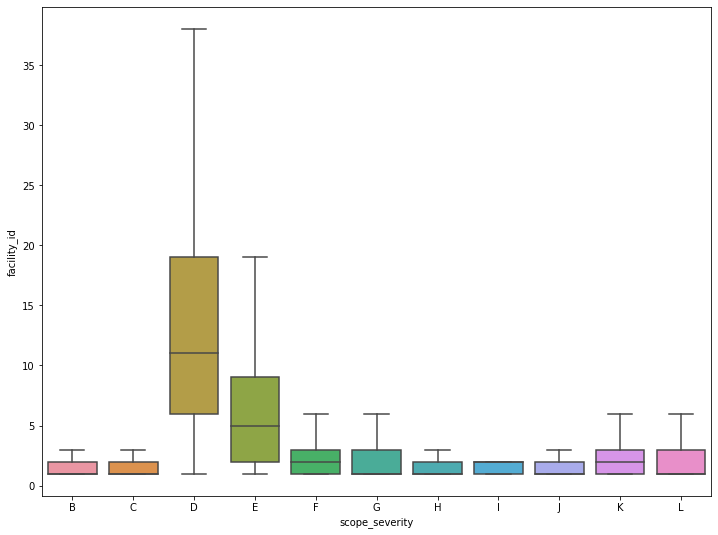

In [124]:
fig, ax = plt.subplots(1,1, figsize=(12,9))
sns.boxplot(
    y="facility_id", 
    x="scope_severity", 
    data=company_counts, 
    ax=ax,
    order=["B","C","D","E","F","G","H","I","J","K","L"],
    showfliers=False,
)

In [127]:
company_counts[company_counts.facility_id == company_counts.facility_id.max()]

,facility_name,scope_severity,facility_id
29867,MILLER'S MERRY MANOR,D,351


In [31]:
nursing_w_pop[nursing_w_pop.facility_name == "MILLER'S MERRY MANOR"].groupby(
    ["city","scope_severity"], as_index=False
).facility_id.count().pivot(
    index="city",columns="scope_severity", values="facility_id").fillna(0).astype(int)

scope_severity,B,C,D,E,F,G,J
city,,,,,,,
CHESTERFIELD,0,0,11,1,0,1,0
COLUMBIA CITY,0,0,5,2,1,0,0
DUNKIRK,0,0,11,2,0,0,0
FORT WAYNE,0,0,4,4,0,0,0
GARRETT,0,0,8,1,0,0,0
HARTFORD CITY,0,0,10,1,1,0,0
HOBART,0,0,39,6,0,1,0
HOPE,0,0,10,2,1,1,2
HUNTINGTON,0,0,16,4,0,0,0


In [25]:
# pivot to set severity as columns
company_counts_piv = (
    company_counts.pivot(
        index="facility_name", columns="scope_severity", values="facility_id"
    )
    .fillna(0)
    .astype(int)
)

# compute total incidents
company_counts_piv["total"] = company_counts_piv.sum(axis=1)

# sort by total
company_counts_piv = company_counts_piv.sort_values(by=["total"], ascending=False)

company_counts_piv.head()

scope_severity,B,C,D,E,F,G,H,I,J,K,L,total
facility_name,,,,,,,,,,,,
MILLER'S MERRY MANOR,2,1,351,51,7,12,0,0,3,0,0,427
MANORCARE HEALTH SERVICES,4,4,144,33,10,8,0,0,6,1,0,210
"GROVE AT NORTH HUNTINGDON, THE",1,1,114,48,2,7,0,0,2,0,0,175
APERION CARE BLOOMINGTON,0,6,114,34,10,6,0,0,0,0,1,171
COMMUNITY CARE CENTER,4,6,102,40,10,7,0,0,0,0,0,169


In [43]:
# get a count of facilities for each company
nursing_w_pop.groupby(
    ["facility_name"]
)["city"].nunique().sort_values(ascending=False)[:10] # 10 highest counts

facility_name
MILLER'S MERRY MANOR          27
MANORCARE HEALTH SERVICES     10
LITTLE SISTERS OF THE POOR     6
PARKVIEW CARE CENTER           6
JEANNE JUGAN RESIDENCE         5
COMMUNITY CARE CENTER          5
HERITAGE CARE CENTER           4
MOUNTAIN VIEW CARE CENTER      4
CHRISTIAN HEALTH CENTER        4
MITCHELL MANOR                 3
Name: city, dtype: int64

### Which individual facilites do we want to avoid?
Grouping the inspections by company can have the unfair effect of penalizing those companies with lots of facilities, so let's look at individual facilites as well.

In [32]:
# comput number of incidents by individual facility and severity
facility_counts = nursing_w_pop.groupby(
    ["facility_name", "city", "state", "scope_severity"], as_index=False
)["facility_id"].count()

# create a unique facility name
facility_counts["facility"] = (
    facility_counts.facility_name
    + " - "
    + facility_counts.city
    + ", "
    + facility_counts.state
)

# pivot to set severity as columns
facility_counts_piv = (
    facility_counts.pivot(
        index="facility", columns="scope_severity", values="facility_id"
    )
    .fillna(0)
    .astype(int)
)

# compute columns
facility_counts_piv["total"] = facility_counts_piv.sum(axis=1)

# sort by total
facility_counts_piv = facility_counts_piv.sort_values(by=["total"], ascending=False)

# let's just look at the top 10
facility_counts_piv.head(10)

scope_severity,B,C,D,E,F,G,H,I,J,K,L,total
facility,,,,,,,,,,,,
"GROVE AT NORTH HUNTINGDON, THE - NORTH HUNTINGDON, PA",1,1,114,48,2,7,0,0,2,0,0,175
"APERION CARE BLOOMINGTON - BLOOMINGTON, IL",0,6,114,34,10,6,0,0,0,0,1,171
"LAKEWOOD HEALTHCARE CENTER - DOWNEY, CA",4,2,88,48,0,8,0,0,0,0,0,150
"RIVERSIDE POSTACUTE CARE - RIVERSIDE, CA",0,1,127,12,3,0,2,0,0,4,0,149
"CORONA POST ACUTE - CORONA, CA",0,0,104,25,6,4,0,0,1,3,0,143
"GARDENS AT WEST SHORE, THE - CAMP HILL, PA",2,1,85,43,2,4,0,0,3,0,1,141
"CHAMPAIGN URBANA NRSG & REHAB - SAVOY, IL",0,2,101,24,7,2,0,0,1,0,0,137
"PARAMOUNT REHABILITATION AND NURSING - SEATTLE, WA",1,0,84,34,9,5,0,0,3,0,0,136
"ASHLAND NURSING AND REHABILITATION - ASHLAND, VA",0,2,87,32,4,0,0,0,1,2,0,128


In [71]:
# define severe
facility_counts_piv["severe"] = facility_counts_piv[["I", "J", "K", "L"]].sum(axis=1)

# define mid
facility_counts_piv["mid"] = facility_counts_piv[["F", "G", "H"]].sum(axis=1)

# define low
facility_counts_piv["low"] = facility_counts_piv[["B", "C", "D", "E"]].sum(axis=1)

# sort by severe count
facility_counts_severe = facility_counts_piv.sort_values(by="severe", ascending=False)
facility_counts_severe.head(10)

scope_severity,B,C,D,E,F,G,H,I,J,K,L,total,severe,mid,low
facility,,,,,,,,,,,,,,,
"RIVER HAVEN NURSING AND REHABILITATION CENTER - PADUCAH, KY",0,0,25,6,1,0,0,0,18,5,0,55,23,1,31
"LEGEND OAKS HEALTHCARE AND REHABILITATION - NORTH/ - HOUSTON, TX",0,0,7,12,6,9,2,0,3,9,6,54,18,17,19
"METRON OF BELDING - BELDING, MI",0,1,40,19,6,8,0,0,4,9,4,91,17,14,60
"PINEHILL NURSING CENTER - BYROMVILLE, GA",0,1,26,8,6,2,0,0,10,0,6,59,16,8,35
"PLEASANT VIEW NURSING CENTER - METTER, GA",0,0,10,6,1,0,0,0,8,3,5,33,16,1,16
"MOUNTAIN MANOR OF PAINTSVILLE - PAINTSVILLE, KY",0,0,33,9,2,0,0,0,9,7,0,60,16,2,42
"BROOKHAVEN TN OPCO, LLC - KINGSPORT, TN",0,0,12,1,0,3,0,0,8,7,0,31,15,3,13
"BAILEY PARK CLC - HUMBOLDT, TN",0,0,12,3,2,0,0,0,0,14,0,31,14,2,15
"CORPUS NURSING AND REHABILITATION LP - CORPUS CHRISTI, TX",1,3,1,41,2,1,1,0,0,10,4,64,14,4,46


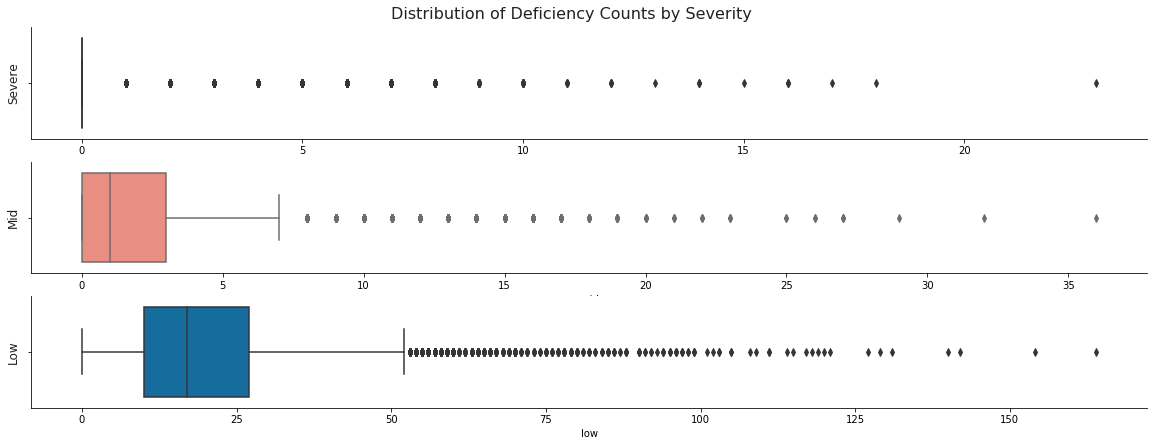

In [128]:
fig, ax = plt.subplots(3,1, figsize=(20,7))
g1 = sns.boxplot(x="severe", data=facility_counts_severe, ax=ax[0])
g2 = sns.boxplot(x="mid", data=facility_counts_severe, ax=ax[1], color="salmon")
g3 = sns.boxplot(x="low", data=facility_counts_severe, ax=ax[2])

fig.suptitle("Distribution of Deficiency Counts by Severity", fontsize=16, color="#222222", y=0.92)

ax[0].set_ylabel("Severe", fontsize=12, color="#222222")
ax[1].set_ylabel("Mid", fontsize=12, color="#222222")
ax[2].set_ylabel("Low", fontsize=12, color="#222222")

# hide top and right frame
sns.despine(top=True, right=True)
plt.savefig("img/nursing/severity_distribution.png", bbox_inchex="tight")

In [136]:
most_severe_count = facility_counts_severe[["severe"]].sort_values(by="severe", ascending=False).head(20)

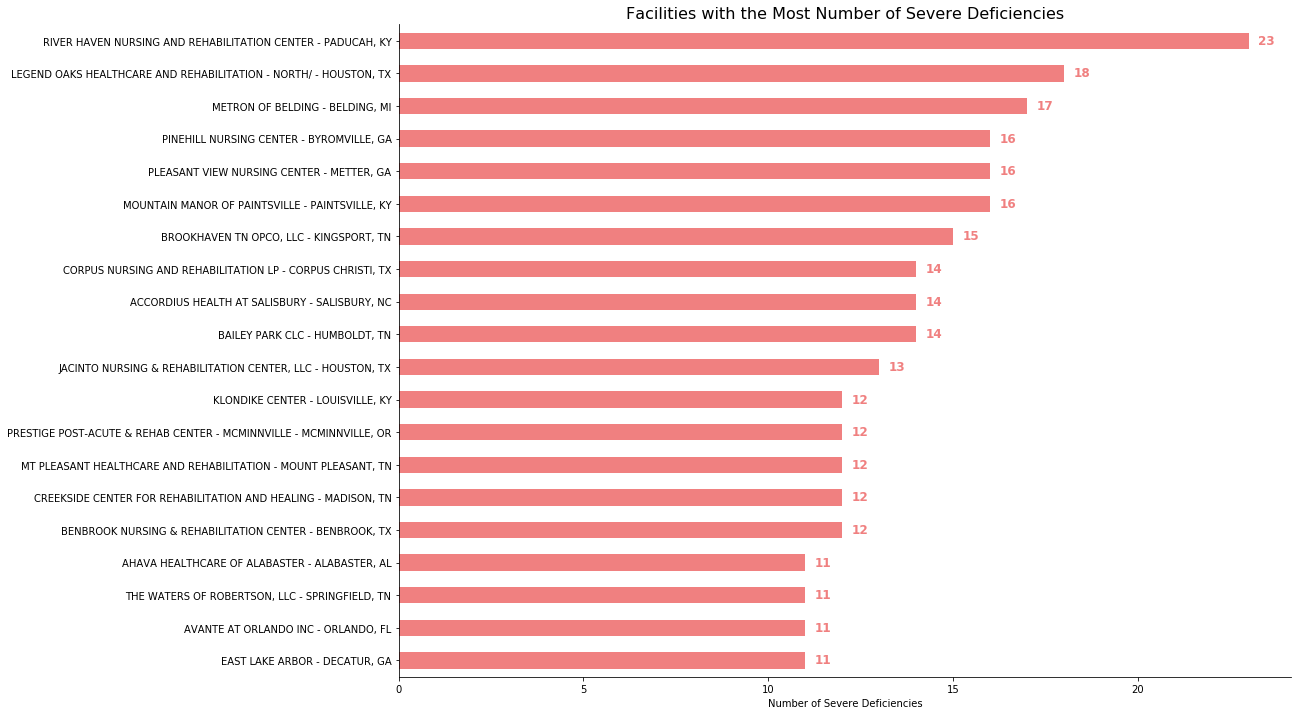

In [147]:
fig, ax = plt.subplots(1,1,figsize=(16,12))
most_severe_count[::-1].plot.barh(ax=ax, color="lightcoral")
for i, v in enumerate(most_severe_count.severe[::-1]):
    ax.text(v + 0.25, i-0.1, str(v), color='lightcoral', fontweight='bold', fontsize=12)

ax.set_title("Facilities with the Most Number of Severe Deficiencies", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel(None)
ax.set_xlabel("Number of Severe Deficiencies")
ax.get_legend().remove()
plt.savefig("img/nursing/most_severe_count.png", bbox_inches="tight")

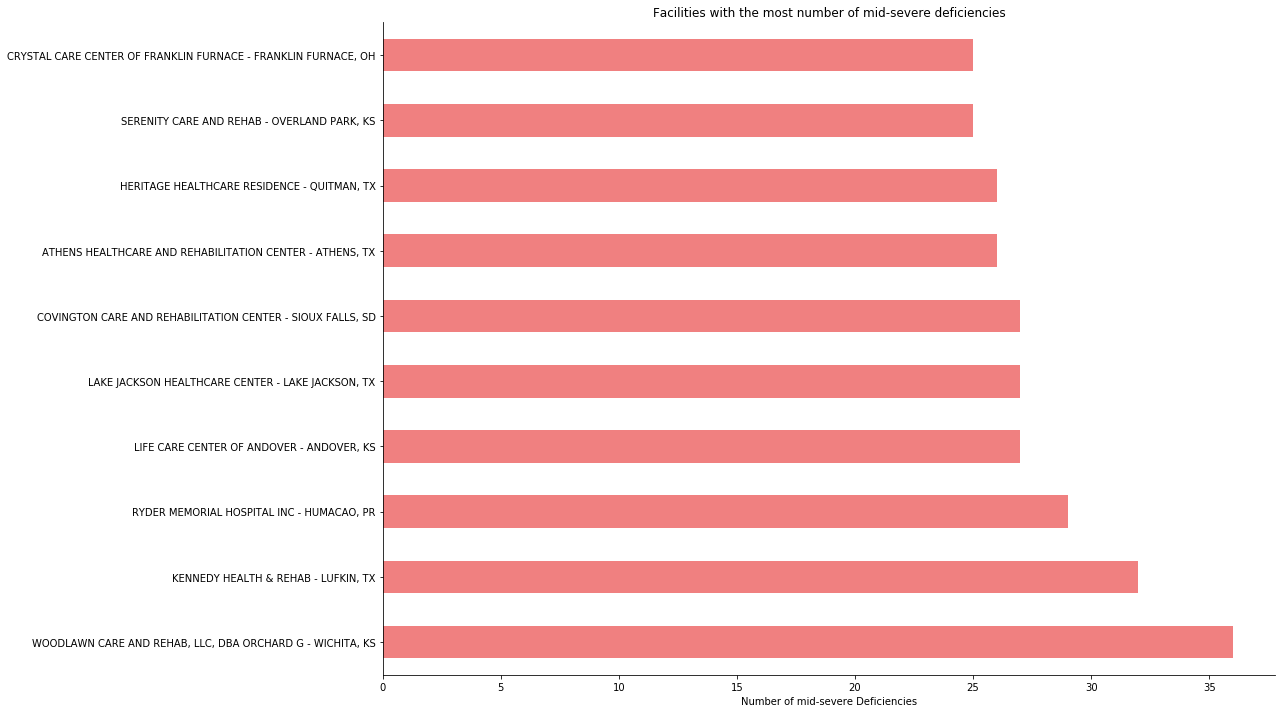

In [83]:
# sort by mid severity
fig, ax = plt.subplots(figsize=(16,12))
facility_counts_piv.sort_values(by="mid", ascending=False)[["mid"]][:10].plot.barh(ax=ax, color="lightcoral")
ax.set_title("Facilities with the most number of mid-severe deficiencies")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel(None)
ax.set_xlabel("Number of mid-severe Deficiencies")
ax.get_legend().remove()

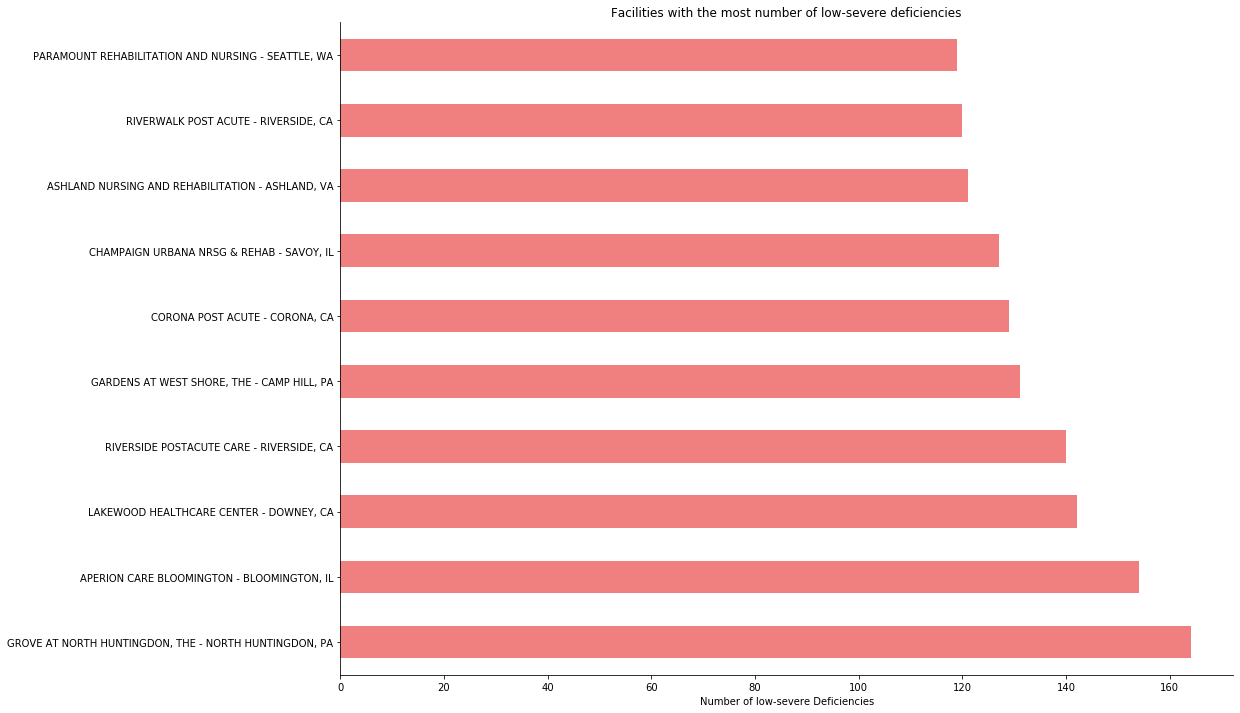

In [84]:
# sort by mid severity
fig, ax = plt.subplots(figsize=(16,12))
facility_counts_piv.sort_values(by="low", ascending=False)[["low"]][:10].plot.barh(ax=ax, color="lightcoral")
ax.set_title("Facilities with the most number of low-severe deficiencies")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel(None)
ax.set_xlabel("Number of low-severe Deficiencies")
ax.get_legend().remove()

Text(0.5, 0, 'Number of Inspections')

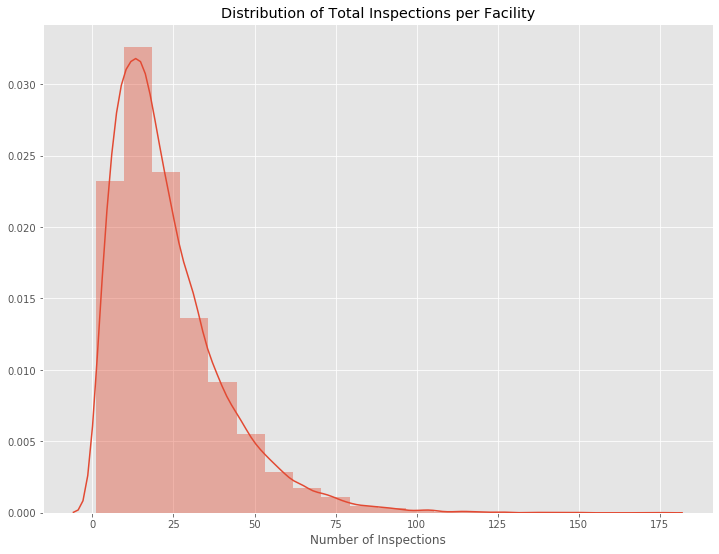

In [84]:
# plot distribution of inspections per facility
plt.figure(figsize=(12,9))
sns.distplot(facility_counts_piv.total, bins=20)
plt.title("Distribution of Total Inspections per Facility")
plt.xlabel("Number of Inspections")
plt.xlim(0, facility_counts_piv.total.max())

## Are some states worse than others?

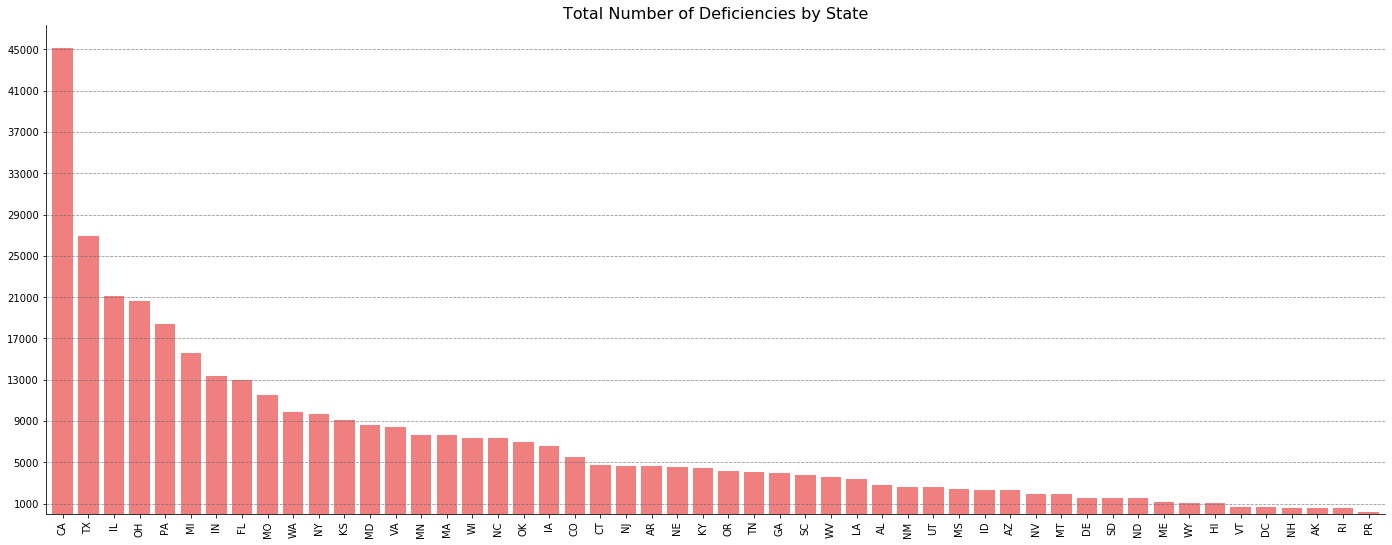

In [149]:
# plot total incidents by state
ax = nursing_w_pop.state.value_counts().plot.bar(width=0.8, figsize=(24,9), color="lightcoral")
ax.set_title("Total Number of Deficiencies by State", fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(which="both", axis="y", color="dimgrey", linestyle="--", alpha=0.7)
yticks = np.arange(1000,46000,4000)
_ = ax.set_yticks(yticks.tolist())
plt.savefig("img/nursing/incidents_by_state.png")

In [88]:
# compute total incidents by state and year
state_totals_by_year = nursing_w_pop.groupby(
    ["state", "year", "state_pop"], as_index=False
)["facility_id"].count()

# compute total incidents per 10,000 residents by stat`be
state_totals_by_year["rel_total"] = (
    state_totals_by_year.facility_id / state_totals_by_year.state_pop * 10000
)

# group by state and compute relative total mean
state_totals = pd.DataFrame(
    state_totals_by_year.groupby(["state"], as_index=False)["rel_total"].mean()
).sort_values(by="rel_total", ascending=False)

In [151]:
from matplotlib.lines import Line2D

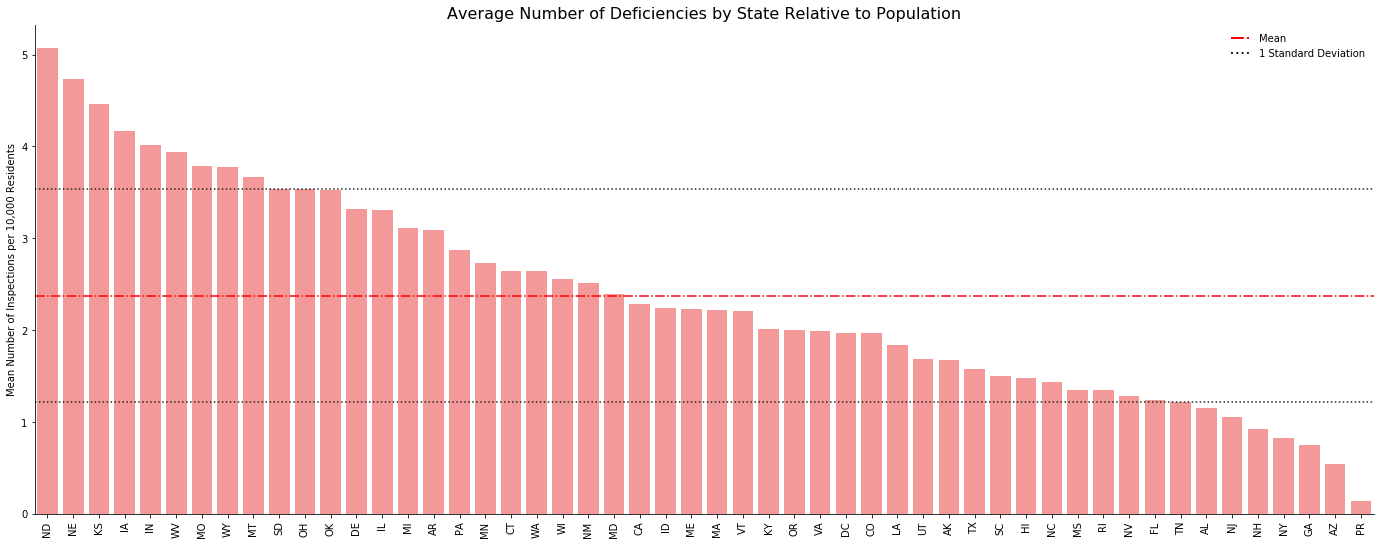

In [156]:
fig, ax = plt.subplots(figsize=(24, 9))
ax.bar(
    x=state_totals.state, height=state_totals.rel_total, color="lightcoral", alpha=0.8
)
ax.set_title(
    "Average Number of Deficiencies by State Relative to Population", fontsize=16
)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# ax.grid(which="both", axis="y", color="dimgrey", linestyle="--", alpha=0.7)
ax.set_ylabel("Mean Number of Inspections per 10,000 Residents")
ax.tick_params(axis="x", labelrotation=90)
ax.set_xlim(-0.5, len(state_totals) - 0.5)

# draw mean and standard deviation lines
ax.axhline(y=state_totals.rel_total.mean(), ls="-.", c="r")
ax.axhline(
    y=(state_totals.rel_total.mean() + state_totals.rel_total.std()),
    ls=":",
    c="#222222",
)
ax.axhline(
    y=(state_totals.rel_total.mean() - state_totals.rel_total.std()),
    ls=":",
    c="#222222",
)

custom_lines = [
    Line2D([0], [0], color="r", lw=2, ls="-."),
    Line2D([0], [0], color="#222222", lw=2, ls=":"),
]
ax.legend(custom_lines, ["Mean", "1 Standard Deviation"], frameon=False)
plt.savefig("img/nursing/avg_deficiencies_by_state.png", bbox_inches="tight")

In [97]:
# compute monthly totals 
monthly_totals = pd.DataFrame(
    nursing_w_pop[
        (nursing_w_pop.inspection_date >= "2016-06-01")
        & (nursing_w_pop.inspection_date < "2019-04-01") # lack of info past April 2019
    ]
    .groupby(["month_year"], as_index=False)["complaint"]
    .sum()
)

# create month number for plot
monthly_totals["month_no"] = range(len(monthly_totals))

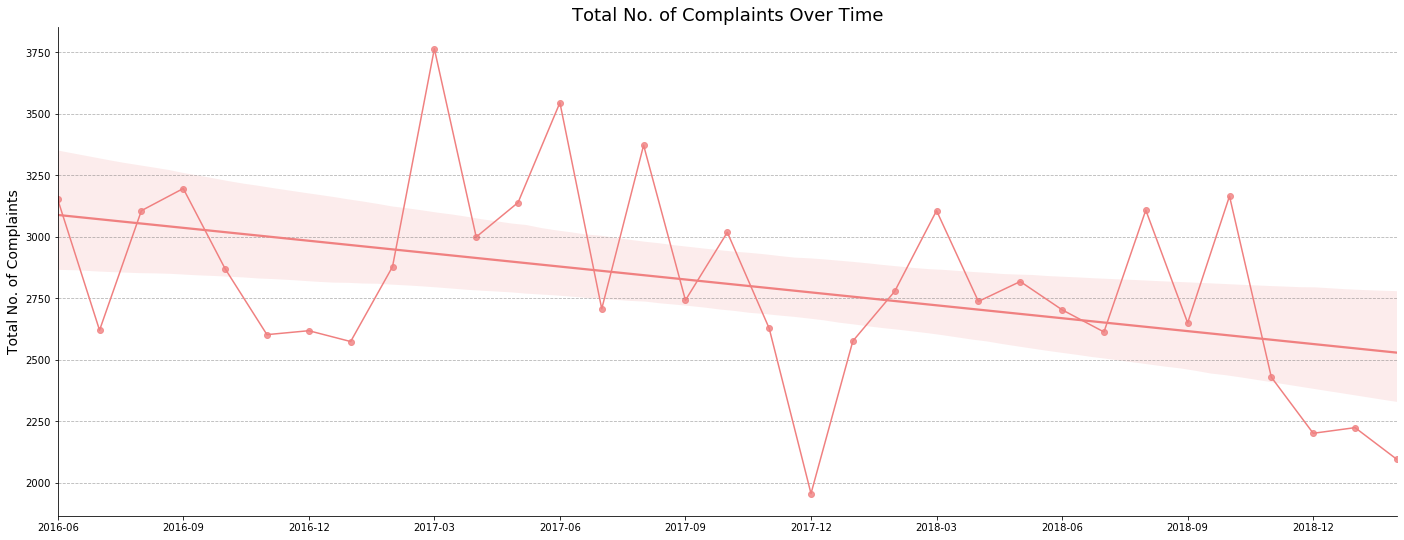

In [163]:
# plot total incidents by month with regression line
plt.figure(figsize=(24, 9))
ax = sns.regplot(
    x="month_no",
    y="complaint",
    data=monthly_totals[monthly_totals.month_year < "2019-03"],
    color="lightcoral",
)
sns.lineplot(
    x="month_no",
    y="complaint",
    data=monthly_totals[monthly_totals.month_year < "2019-03"],
    ax=ax,
    color="lightcoral",
)
ax.set_xticklabels(
    monthly_totals[monthly_totals.month_year < "2019-03"]
    .month_year.astype(str)
    .values.tolist()[::3]
)
ax.set_xticks(np.arange(0, 32, 3))
ax.set_xlim([0, 32])
ax.set_ylabel("Total No. of Complaints", fontsize=14)
ax.set_xlabel(None)
ax.set_title("Total No. of Complaints Over Time", fontsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(which="major", axis="y", color="dimgrey", linestyle="--", alpha=0.5)
plt.savefig("img/nursing/deficiency_totals_over_time.png", bbox_inches="tight")

In [118]:
most_severe = pd.DataFrame(
    nursing_w_pop[nursing_w_pop["scope_severity"] == "L"]
    .groupby(["state", "year", "state_pop"], as_index=False)["facility_id"]
    .count()
)
most_severe["rel_total"] = (
    most_severe.facility_id / most_severe.state_pop * 10000
)

In [123]:
most_severe.groupby("state").rel_total.mean().sort_values(ascending=False).head()

state
SD    0.160314
ID    0.046977
DC    0.028472
WV    0.027688
KS    0.025766
Name: rel_total, dtype: float64

Text(0.5, 1.0, 'Average Severe (L) Deficiencies Per 1000 Citizens by State')

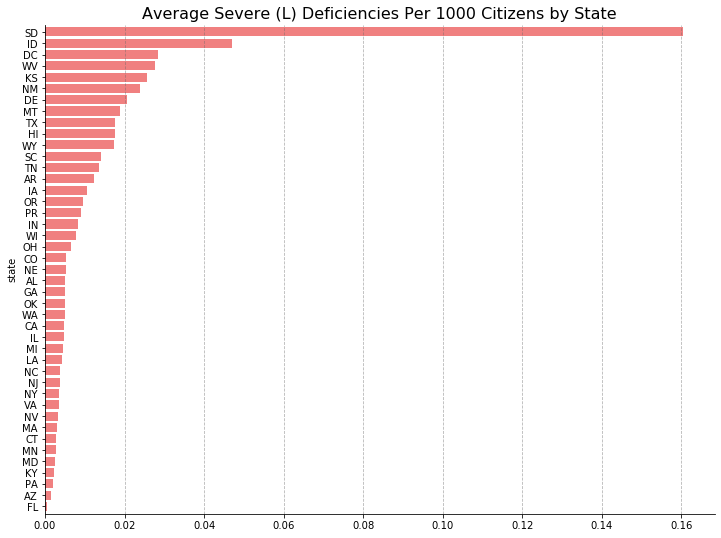

In [160]:
fig, ax = plt.subplots(figsize=(12, 9))
most_severe.groupby("state").rel_total.mean().sort_values().plot.barh(
    ax=ax, color="lightcoral", width=0.8
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(which="both", axis="x", color="dimgrey", linestyle="--", alpha=0.5)
ax.set_title("Average Severe (L) Deficiencies Per 1000 Citizens by State", fontsize=16)